In [1]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [2]:
train_sparse = load_npz('train_10k_sparse_matrix.npz').tocsr()
test_sparse = load_npz('test_10k_sparse_matrix.npz').tocsr()

train = pd.read_csv('train_10k.csv')
test = pd.read_csv('test_10k.csv')

In [3]:
with open('users_10k_id_for_sparse.txt', 'r') as fp:
    users_id_for_sparse = json.load(fp)
    
with open('songs_10k_id_for_sparse.txt', 'r') as fp:
    songs_id_for_sparse = json.load(fp)

In [4]:
train["user_id"] = train["user_id"].map(users_id_for_sparse)
train["song_id"] = train["song_id"].map(songs_id_for_sparse)
test["user_id"] = test["user_id"].map(users_id_for_sparse)
test["song_id"] = test["song_id"].map(songs_id_for_sparse)

In [5]:
# делаем SVD
u, s, vt = svds(train_sparse, k=10)

s_diag_matrix = np.diag(s)

In [6]:
# предсказываем
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

In [7]:
X_pred.shape

(10000, 88058)

In [8]:
pred = []
for row_id in tqdm(np.arange(test_sparse.shape[0])):
    score = pd.Series(X_pred[row_id, :])
    score = list(pd.Series(score.sort_values(ascending=False).index))
    
    pred_items = score[:50]
    
    pred.append(pred_items)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
num_users, num_songs = train.user_id.nunique(), train.song_id.nunique()
num_users, num_songs

(10000, 81458)

In [10]:
def remove_train_items(preds, k):
    new_preds = np.zeros((preds.shape[0], k), dtype=np.int)
    for user, data in train.groupby('user_id'):
        user_preds = preds[user]
        new_preds[user] = user_preds[~np.in1d(user_preds, data.song_id)][:k]
    return new_preds


def get_random_preds(k=10):
    preds = np.tile(np.arange(num_songs), (num_users, 1))
    for i in range(num_users):
        rand_perm = np.random.permutation(num_songs)
        preds[i] = preds[i][rand_perm]

    preds = remove_train_items(preds, k)
    return preds

def get_toppop_preds(freq=10, k=10):
    mean_rating = train.groupby('song_id').play_count.mean()
    mean_rating = mean_rating[train.groupby('song_id').size() >= freq]
    preds = np.array(mean_rating.sort_values(ascending=False).index)
    preds = np.tile(preds, (num_users, 1))
    preds = remove_train_items(preds, k)
    return preds


def MAP_k(true, pred, k):
    m = 0
    num = min(len(true), len(pred))
    for tr, pr in zip(true, pred):
        if not tr:
            continue
        tr_in_pr = np.isin(pr[:k], tr)
        m += (tr_in_pr / np.arange(1, k + 1)).sum() / (1 / np.arange(1, len(tr) + 1)).sum()
    m = m / num
    return m

In [11]:
true_relevant = []
for user, data in test[test.play_count >= 3].groupby('user_id'):
    true_relevant += [data.song_id.tolist()]

In [12]:
ks = np.arange(1, 20)
random_preds = get_random_preds(k=ks[-1])
top_preds = get_toppop_preds(freq=10, k=ks[-1])

random_map_k = [MAP_k(true_relevant, random_preds, k=k) for k in ks]
top_map_k = [MAP_k(true_relevant, top_preds, k=k) for k in ks]
svd_map_k = [MAP_k(true_relevant, pred, k=k) for k in ks]
# als_map_k = [MAP_k(true_relevant, als_preds, k=k) for k in ks]

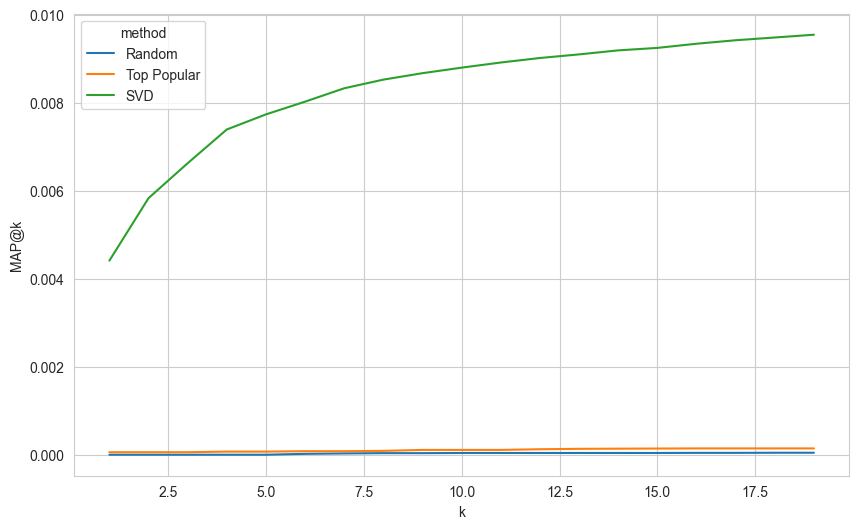

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(ks, random_map_k, label='Random')
plt.plot(ks, top_map_k, label='Top Popular')
plt.plot(ks, svd_map_k, label='SVD')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

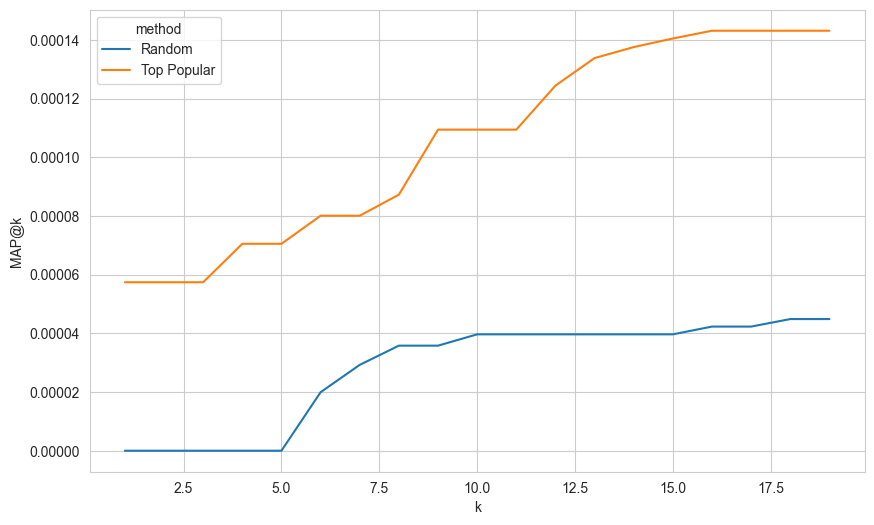

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(ks, random_map_k, label='Random')
plt.plot(ks, top_map_k, label='Top Popular')


plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()